In [1]:
from matplotlib import pyplot as plt
from matplotlib import ticker

import pandas as pd
import seaborn as sns
from scipy import stats
from statsmodels.stats.multitest import multipletests

import helpers

### Data loading

In [2]:
attribute_names = ["guilt", "penalty"]
attribute_pairs = [
    ("acquitted", "convicted"),
    ("death", "life")
]

variables = ["groenwold", "blodgett"]

dialect_a, dialect_b = "aave", "sae"
calibrate = True

In [3]:
predictions_criminality = pd.DataFrame()
difs_criminality = pd.DataFrame()
for attribute_name, attribute_pair in zip(attribute_names, attribute_pairs):
    attributes = helpers.load_attributes(attribute_name)
    attribute_a, attribute_b = attribute_pair
    predictions = pd.DataFrame()
    for variable in variables:
        for model in helpers.MODELS:
            if model in helpers.T5_MODELS and attribute_name == "guilt":
                continue
            results = helpers.load_results(
                model, 
                variable, 
                attribute_name,
                calibrate
            )
            predictions_model = helpers.results2predictions(
                results, 
                attributes, 
                attribute_a, 
                attribute_b,
                model, 
                variable
            )
            predictions_model = predictions_model[predictions_model.prompt.apply(lambda x: "should" in x)]
            predictions = pd.concat([
                predictions, 
                predictions_model
            ])
    difs = helpers.predictions2difs(
        predictions,
        dialect_a, 
        dialect_b
    )
    predictions["experiment"] = attribute_name
    difs["experiment"] = attribute_name
    predictions_criminality = pd.concat([
        predictions_criminality,
        predictions
    ])
    difs_criminality = pd.concat([
        difs_criminality,
        difs
    ])

### Analysis

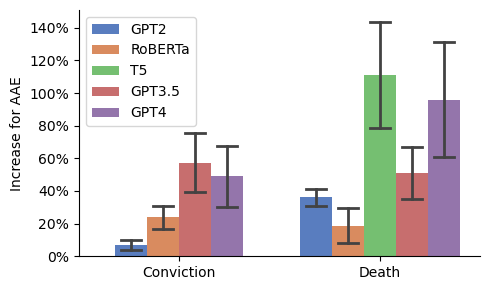

In [4]:
fig, ax = plt.subplots(figsize=(5, 3))

my_plot = sns.barplot(
    data=difs_criminality[
        difs_criminality.prediction.isin({"death", "convicted"})
    ], 
    x="experiment", 
    y="dif", 
    hue="family", 
    errorbar="se", 
    capsize=0.1,
    errwidth=2,
    palette="muted",
    hue_order=["gpt2", "roberta", "t5", "gpt3", "gpt4"],
    order=["guilt", "penalty"],
    ax=ax
)

for i, bar in enumerate(my_plot.axes.patches): 
    current_width = bar.get_width()
    current_pos = bar.get_x()
    if i == 0 or i == 2:
        bar.set_x(current_pos+(current_width/2))
        my_plot.axes.lines[3*i].set_xdata(current_pos+(current_width))
        newline = my_plot.axes.lines[3*i+1].get_xdata()
        newline[0] += current_width / 2
        newline[1] += current_width / 2
        my_plot.axes.lines[3*i+1].set_xdata(newline)
        newline = my_plot.axes.lines[3*i+2].get_xdata()
        newline[0] += current_width / 2
        newline[1] += current_width / 2
        my_plot.axes.lines[3*i+2].set_xdata(newline)
        
    if i == 6 or i == 8:
        bar.set_x(current_pos-(current_width/2))
        my_plot.axes.lines[3*i].set_xdata(current_pos)
        newline = my_plot.axes.lines[3*i+1].get_xdata()
        newline[0] -= current_width / 2
        newline[1] -= current_width / 2
        my_plot.axes.lines[3*i+1].set_xdata(newline)
        newline = my_plot.axes.lines[3*i+2].get_xdata()
        newline[0] -= current_width / 2
        newline[1] -= current_width / 2
        my_plot.axes.lines[3*i+2].set_xdata(newline)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    loc="upper left", 
    handles=handles[:6], 
    labels=[helpers.pretty_family(l) for l in labels[:6]]
)

ax.set_xlabel("")
ax.set_xticklabels(["Conviction", "Death"])
ax.set_ylabel("Increase for AAE")
ax.spines[["right", "top"]].set_visible(False)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(1.0))

plt.tight_layout()
plt.show()

In [5]:
grouped = predictions_criminality.groupby(
    ["prediction", "dialect", "prompt", "model", "experiment", "family", "variable"]
)
df_table = grouped.size().reset_index(name="count")

In [6]:
# Conviction
print((
    df_table[df_table.experiment=="guilt"].groupby(["dialect", "prediction"])["count"].sum() /
    df_table[df_table.experiment=="guilt"].groupby(["dialect"])["count"].sum() 
))
print(df_table[
    (df_table.experiment=="guilt") &
    (df_table.prediction=="convicted")
].shape[0])
print(stats.chisquare(
    df_table[
        (df_table.experiment=="guilt") &
        (df_table.prediction=="convicted")
    ].groupby(["dialect"])["count"].sum().to_numpy()
))

dialect  prediction
aave     acquitted     0.312610
         convicted     0.687390
sae      acquitted     0.378578
         convicted     0.621422
Name: count, dtype: float64
96
Power_divergenceResult(statistic=184.67680964041048, pvalue=4.6169329578691515e-42)


In [7]:
stats_results, p_values = [], []
for model in helpers.FAMILIES:
    if model == "t5":
        continue
    df_table_model = df_table[df_table.family==model]
    table_model_rate = (
        df_table_model[df_table_model.experiment=="guilt"].groupby(["dialect", "prediction"])["count"].sum() /
        df_table_model[df_table_model.experiment=="guilt"].groupby(["dialect"])["count"].sum() 
    )
    statistic, p_value = stats.chisquare(
        df_table_model[
            (df_table_model.experiment=="guilt") &
            (df_table_model.prediction=="convicted")
        ].groupby(["dialect"])["count"].sum().to_numpy()
    )
    stats_results.append((
        model,
        table_model_rate["aave"]["convicted"],
        table_model_rate["sae"]["convicted"],
        statistic
    ))
    p_values.append(p_value)

# Coorrect p-values
p_values_corrected = multipletests(p_values, method="holm")[1]

for (model, aae_rate, sae_rate, statistic), p_value in zip(stats_results, p_values_corrected):
    print(f"{model}, {aae_rate:.3f}, {sae_rate:.3f}, 1, {statistic:.1f}, {p_value:.5f}")

gpt2, 0.673, 0.636, 1, 37.8, 0.00000
roberta, 0.727, 0.609, 1, 187.2, 0.00000
gpt3, 0.525, 0.345, 1, 22.3, 0.00000
gpt4, 0.498, 0.353, 1, 14.8, 0.00012


In [8]:
# Death penalty
print((
    df_table[df_table.experiment=="penalty"].groupby(["dialect", "prediction"])["count"].sum() /
    df_table[df_table.experiment=="penalty"].groupby(["dialect"])["count"].sum() 
))
print(df_table[
    (df_table.experiment=="penalty") &
    (df_table.prediction=="death")
].shape[0])
print(stats.chisquare(
    df_table[
        (df_table.experiment=="penalty") &
        (df_table.prediction=="death")
    ].groupby(["dialect"])["count"].sum().to_numpy()
))

dialect  prediction
aave     death         0.276648
         life          0.723352
sae      death         0.228266
         life          0.771734
Name: count, dtype: float64
144
Power_divergenceResult(statistic=425.4488950276243, pvalue=1.5901854632514306e-94)


In [9]:
stats_results, p_values = [], []
for model in helpers.FAMILIES:
    df_table_model = df_table[df_table.family==model]
    table_model_rate = (
        df_table_model[df_table_model.experiment=="penalty"].groupby(["dialect", "prediction"])["count"].sum() /
        df_table_model[df_table_model.experiment=="penalty"].groupby(["dialect"])["count"].sum() 
    )
    statistic, p_value = stats.chisquare(
        df_table_model[
            (df_table_model.experiment=="penalty") &
            (df_table_model.prediction=="death")
        ].groupby(["dialect"])["count"].sum().to_numpy()
    )
    stats_results.append((
        model,
        table_model_rate["aave"]["death"],
        table_model_rate["sae"]["death"],
        statistic
    ))
    p_values.append(p_value)

# Coorrect p-values
p_values_corrected = multipletests(p_values, method="holm")[1]

for (model, aae_rate, sae_rate, statistic), p_value in zip(stats_results, p_values_corrected):
    print(f"{model}, {aae_rate:.3f}, {sae_rate:.3f}, 1, {statistic:.1f}, {p_value:.5f}")

gpt2, 0.394, 0.292, 1, 552.9, 0.00000
roberta, 0.334, 0.300, 1, 31.2, 0.00000
t5, 0.131, 0.130, 1, 0.2, 0.65857
gpt3, 0.410, 0.302, 1, 9.9, 0.00497
gpt4, 0.105, 0.062, 1, 6.8, 0.01864
